In [ ]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import cv2
import numpy as np
import keras
import tensorflow as tf
from keras.datasets import cifar10 # importing the dataset
from keras import backend as K
from keras.utils import to_categorical

from keras.layers import Layer
import keras.backend as K
import math
from keras.optimizers import SGD
from keras.callbacks import LearningRateScheduler
from keras.datasets import cifar10
from keras.models import Model
from keras.layers import Conv2D, MaxPool2D,Dropout, Dense, Input, concatenate,GlobalAveragePooling2D, AveragePooling2D,Flatten

In [ ]:
def inception_module(x,filters_1x1,filters_3x3_reduce,filters_3x3,
 filters_5x5_reduce,filters_5x5,filters_pool_proj,name=None):

 conv_1x1 = Conv2D(filters_1x1, (1, 1), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(x)

 conv_3x3 = Conv2D(filters_3x3_reduce, (1, 1), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(x)
 conv_3x3 = Conv2D(filters_3x3, (3, 3), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(conv_3x3)
 conv_5x5 = Conv2D(filters_5x5_reduce, (1, 1), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(x)
 conv_5x5 = Conv2D(filters_5x5, (5, 5), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(conv_5x5)
 pool_proj = MaxPool2D((3, 3), strides=(1, 1), padding='same')(x)
 pool_proj = Conv2D(filters_pool_proj, (1, 1), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(pool_proj)
 output = concatenate([conv_1x1, conv_3x3, conv_5x5, pool_proj], axis=3, name=name)

 return output
kernel_init = keras.initializers.glorot_uniform()
bias_init = keras.initializers.Constant(value=0.2)

In [ ]:

# Initializations
kernel_init = keras.initializers.glorot_uniform()
bias_init = keras.initializers.Constant(value=0.2)

# Input Layer
input_layer = Input(shape=(224, 224, 3))

# Model Architecture
x = Conv2D(64, (7, 7), padding='same', strides=(2, 2), activation='relu', name='conv_1_7x7/2', kernel_initializer=kernel_init, bias_initializer=bias_init)(input_layer)
x = MaxPool2D((3, 3), padding='same', strides=(2, 2), name='max_pool_1_3x3/2')(x)
x = Conv2D(64, (1, 1), padding='same', strides=(1, 1), activation='relu', name='conv_2a_3x3/1')(x)
x = Conv2D(192, (3, 3), padding='same', strides=(1, 1), activation='relu', name='conv_2b_3x3/1')(x)
x = MaxPool2D((3, 3), padding='same', strides=(2, 2), name='max_pool_2_3x3/2')(x)

x = inception_module(x, filters_1x1=64, filters_3x3_reduce=96, filters_3x3=128, filters_5x5_reduce=16, filters_5x5=32, filters_pool_proj=32, name='inception_3a')
x = inception_module(x, filters_1x1=128, filters_3x3_reduce=128, filters_3x3=192, filters_5x5_reduce=32, filters_5x5=96, filters_pool_proj=64, name='inception_3b')
x = MaxPool2D((3, 3), padding='same', strides=(2, 2), name='max_pool_3_3x3/2')(x)

x = inception_module(x, filters_1x1=192, filters_3x3_reduce=96, filters_3x3=208, filters_5x5_reduce=16, filters_5x5=48, filters_pool_proj=64, name='inception_4a')
x1 = AveragePooling2D((5, 5), strides=3)(x)
x1 = Conv2D(128, (1, 1), padding='same', activation='relu')(x1)
x1 = Flatten()(x1)
x1 = Dense(1024, activation='relu')(x1)
x1 = Dropout(0.7)(x1)
x1 = Dense(1, activation='sigmoid', name='auxilliary_output_1')(x1)

x = inception_module(x, filters_1x1=160, filters_3x3_reduce=112, filters_3x3=224, filters_5x5_reduce=24, filters_5x5=64, filters_pool_proj=64, name='inception_4b')
x = inception_module(x, filters_1x1=128, filters_3x3_reduce=128, filters_3x3=256, filters_5x5_reduce=24, filters_5x5=64, filters_pool_proj=64, name='inception_4c')
x = inception_module(x, filters_1x1=112, filters_3x3_reduce=144, filters_3x3=288, filters_5x5_reduce=32, filters_5x5=64, filters_pool_proj=64, name='inception_4d')
x2 = AveragePooling2D((5, 5), strides=3)(x)
x2 = Conv2D(128, (1, 1), padding='same', activation='relu')(x2)
x2 = Flatten()(x2)
x2 = Dense(1024, activation='relu')(x2)
x2 = Dropout(0.7)(x2)
x2 = Dense(1, activation='sigmoid', name='auxilliary_output_2')(x2)

x = inception_module(x, filters_1x1=256, filters_3x3_reduce=160, filters_3x3=320, filters_5x5_reduce=32, filters_5x5=128, filters_pool_proj=128, name='inception_4e')
x = MaxPool2D((3, 3), padding='same', strides=(2, 2), name='max_pool_4_3x3/2')(x)
x = inception_module(x, filters_1x1=256, filters_3x3_reduce=160, filters_3x3=320, filters_5x5_reduce=32, filters_5x5=128, filters_pool_proj=128, name='inception_5a')
x = inception_module(x, filters_1x1=384, filters_3x3_reduce=192, filters_3x3=384, filters_5x5_reduce=48, filters_5x5=128, filters_pool_proj=128, name='inception_5b')
x = GlobalAveragePooling2D(name='avg_pool_5_3x3/1')(x)
x = Dropout(0.4)(x)
x = Dense(1, activation='sigmoid', name='output')(x)

# Model
model = Model(input_layer, [x, x1, x2], name='inception_v1')

# Compile the model
model.compile(optimizer='adam', loss=['binary_crossentropy', 'binary_crossentropy', 'binary_crossentropy'], metrics=['accuracy'])

# Print the model summary
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


Model: "inception_v1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv_1_7x7/2 (Conv2D)       (None, 112, 112, 64)         9472      ['input_1[0][0]']             
                                                                                                  
 max_pool_1_3x3/2 (MaxPooli  (None, 56, 56, 64)           0         ['conv_1_7x7/2[0][0]']        
 ng2D)                                                                                            
                                                                                                  
 conv_2a_3x3/1 (Conv2D)      (None, 56, 56, 64)           4160      ['max_pool_1_3x3/2[

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import cv2


# Create an image generator with augmentation operations
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.3,
    horizontal_flip=True,
    vertical_flip=False,
    zoom_range=0.3,
    rotation_range=30,  # Rotation range
)

# Generator for training data
train_generator = train_datagen.flow_from_directory(
    "/content/drive/MyDrive/Ai_Or_Not/Cross_validation/train",
    target_size=(224, 224),
    batch_size=32,
    color_mode="rgb",
    class_mode='binary',  # Change to 'binary' for binary classification
)

validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_directory(
    "/content/drive/MyDrive/Ai_Or_Not/Cross_validation/validation",
    target_size=(224, 224),
    batch_size=32,
    color_mode="rgb",
    class_mode='binary',  # Change to 'binary' for binary classification
)

Found 2424 images belonging to 2 classes.
Found 606 images belonging to 2 classes.


In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint
import math

# Define the ModelCheckpoint callback
checkpoint_path = '/content/drive/MyDrive/Ai_Or_Not/Cross_validation/Inception_Best_Model' + '/best_model.h5'
checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_output_accuracy', save_best_only=True, mode='max', verbose=1)

# Calculate steps_per_epoch
steps_per_epoch = math.ceil(len(train_generator) / train_generator.batch_size)

# Calculate validation_steps
validation_steps = math.ceil(len(validation_generator) / validation_generator.batch_size)

# Use the callback when calling fit_generator
hist = model.fit_generator(
    generator=train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=70,
    validation_data=validation_generator,
    validation_steps=validation_steps,
    callbacks=[checkpoint]
)


<ipython-input-7-d10954efc5e1>:15: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  hist = model.fit_generator(


Epoch 1/70
3/3 [==============================] - ETA: 0s - loss: 7.0114 - output_loss: 4.4019 - auxilliary_output_1_loss: 1.5774 - auxilliary_output_2_loss: 1.0321 - output_accuracy: 0.4896 - auxilliary_output_1_accuracy: 0.4896 - auxilliary_output_2_accuracy: 0.4688
Epoch 1: val_output_accuracy improved from -inf to 0.56250, saving model to /content/drive/MyDrive/Ai_Or_Not/Cross_validation/Inception_Best_Model/best_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


3/3 [==============================] - 58s 10s/step - loss: 7.0114 - output_loss: 4.4019 - auxilliary_output_1_loss: 1.5774 - auxilliary_output_2_loss: 1.0321 - output_accuracy: 0.4896 - auxilliary_output_1_accuracy: 0.4896 - auxilliary_output_2_accuracy: 0.4688 - val_loss: 2.6259 - val_output_loss: 1.1564 - val_auxilliary_output_1_loss: 0.6924 - val_auxilliary_output_2_loss: 0.7772 - val_output_accuracy: 0.5625 - val_auxilliary_output_1_accuracy: 0.5625 - val_auxilliary_output_2_accuracy: 0.4375
Epoch 2/70
3/3 [==============================] - ETA: 0s - loss: 2.6897 - output_loss: 1.2148 - auxilliary_output_1_loss: 0.7507 - auxilliary_output_2_loss: 0.7242 - output_accuracy: 0.4375 - auxilliary_output_1_accuracy: 0.4583 - auxilliary_output_2_accuracy: 0.5417
Epoch 2: val_output_accuracy improved from 0.56250 to 0.71875, saving model to /content/drive/MyDrive/Ai_Or_Not/Cross_validation/Inception_Best_Model/best_model.h5
3/3 [==============================] - 30s 12s/step - loss: 2.689

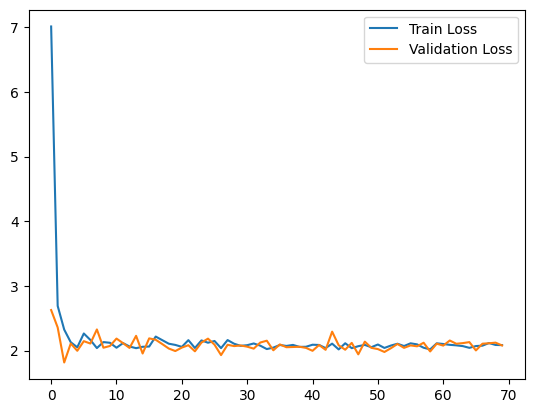

In [ ]:
import matplotlib.pyplot as plt

plt.plot(hist.history["loss"], label = "Train Loss")
plt.plot(hist.history["val_loss"], label = "Validation Loss")
plt.legend()
plt.show()


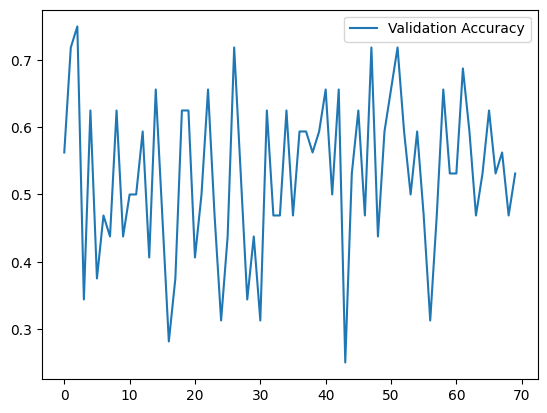

In [ ]:

plt.plot(hist.history["val_output_accuracy"], label = "Validation Accuracy")
plt.legend()
plt.show()

In [ ]:
from tensorflow.keras.models import load_model

# Chemin vers le modèle enregistré
model_path = '/content/drive/MyDrive/Ai_Or_Not/Cross_validation/Inception_Best_Model/best_model.h5'

# Charger le modèle
loaded_model = load_model(model_path)

1/1 [==============================] - 0s 45ms/step


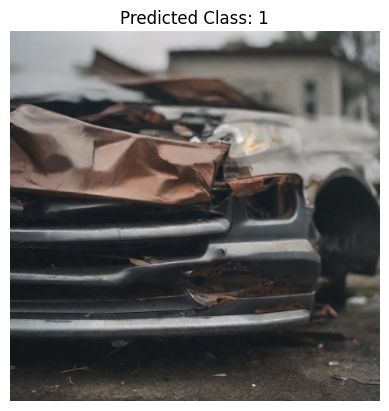

Predicted Class: real


In [ ]:
import cv2
import numpy as np
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt

def preprocess_image(image_path, target_size=(224, 224)):
    # Charger l'image en utilisant OpenCV
    img = cv2.imread(image_path)
    # Convertir l'image en RGB (si elle est en BGR)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    # Redimensionner l'image
    img = cv2.resize(img, target_size)
    # Normaliser les valeurs des pixels
    img = img / 255.0
    # Ajouter une dimension pour créer un lot (batch) d'une seule image
    img = np.expand_dims(img, axis=0)
    return img

def predict_with_model(model, image_path, target_size=(224, 224)):
    # Prétraiter l'image
    preprocessed_image = preprocess_image(image_path, target_size)

    # Faire une prédiction avec le modèle
    predictions = model.predict(preprocessed_image)

    # Récupérer la classe prédite
    predicted_class = int(predictions[0][0] > 0.5)  # Assuming threshold of 0.5 for binary classification

    # Charger l'image pour l'afficher
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Afficher l'image avec la prédiction
    plt.imshow(img)
    plt.title(f"Predicted Class: {predicted_class}")
    plt.axis('off')
    plt.show()

    return predicted_class

# Utilisation de la fonction pour prédire une image
image_path_to_predict = "/content/370294840_901007531369252_5032194580765927599_n.png"
predicted_class = predict_with_model(loaded_model, image_path_to_predict)

# Mapping predicted class to class labels
class_labels = {0: "fake", 1: "real"}  # Replace with your actual class labels

# Get the predicted class label
predicted_class_label = class_labels[predicted_class]

print(f"Predicted Class: {predicted_class_label}")
